# CI-0163 - Análisis de Grandes Volúmenes de Datos 
# Sergio Martínez Calvo B84621
# Tarea 2
* * * 

# Problema
Para esta tarea se eligió un dataset con informacion de los pasajeros abordo del Titanic, contiene datos sobre nombre, edad, número de tiquete, clase de tiquete, etc. Se busca generar un modelo clasificador para predecir si un pasajero sobrevivió o no.

Dataset escogido:  Titanic - Machine Learning from Disaster

https://www.kaggle.com/c/titanic/data?select=train.csv

Dataset procesado: Inicialmente se realizará un análisis exploratorio, preprocesamiento y transformación de datos con la herramienta openRefine por su facilidad para visualizar gráficamente el set de datos, encontrar y corregir errores fácilmente. Posteriormente se usará la librería de Python scikit-learn para generar un clasificador usando los algoritmos de random forest y extra trees, sus resultados serán evaluados con cross-validation para encontrar métricas fiables sobre los modelos y se realizará tuning de parametros para ajustarlos con mayor precisión. Finalmente se discutirá sobre los resultados obtenidos con los modelos antes y despues de su ajuste de hiperparámetros.
* * * 

# Análisis Exploratorio

Para el análisis exploratorio primero se desplegarán estádisticas sobre el dataset para entender los tipos de sus atributos y sus rangos. 

* * *

In [1]:
import pandas as pd
ds = pd.read_csv('train.csv', sep = ',', index_col=0)
ds.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Podemos ver del atributo Survived, el cual es booleano, que el promedio de supervivencia fue de 38%. Esto se nota también viendo el valor de la mediana y el tercer cuartil. Esta es la variable de respuesta del modelo a desarrollar por lo que es de importancia.

Ahora se desplegara graficos sobre atributos como el precio pagado por tiquete y la clase del pasajero para entender mejor su distribución.

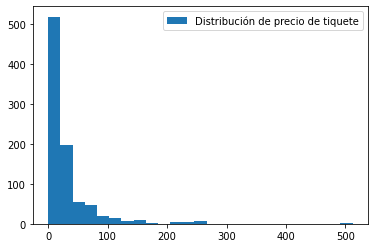

In [2]:
import matplotlib.pyplot as plt
plt.hist(ds["Fare"], bins = 25, label = 'Distribución de precio de tiquete')
plt.legend()
plt.show()

Se puede ver que la gran mayoría de los pasajeros pagaron menos de $50 por su tiquete, por lo que se podría pensar que gran parte de las observaciones pertenecen a la tercera clase.

Ahora se estudiará la distribucion de pasajeros por clase.

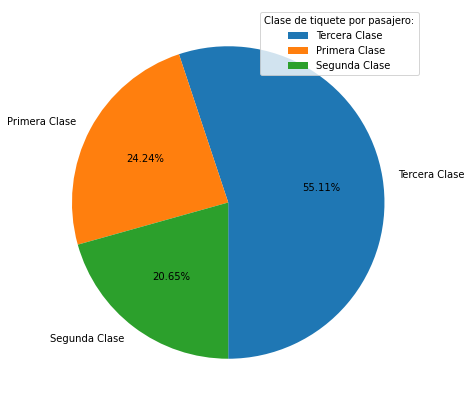

In [3]:
fig = plt.figure(figsize =(7, 8))
plt.pie(ds['Pclass'].value_counts(), labels = ['Tercera Clase', 'Primera Clase', 'Segunda Clase'],autopct='%1.2f%%', startangle=270)
plt.legend(title = "Clase de tiquete por pasajero:")
plt.show()

Se puede ver que hay una mayoría en la tercera clase como es esperado. Sin embargo, siguiendo el hilo de pensamiento de precio por tiquete deberia haber menos pasajeros de primera clase que de segunda, interesantemente este no es el caso, parece no haber una relacion clara entre clase y precio por tiquete.
* * *

# Preprocesamiento de Datos
En este apartado se cargará el dataset mencionado en el inicio del documento en openRefine para encontrar errores como campos vacíos, valores 
incorrectos y realizar correciones sobre ellos.

Se adjunta un archivo .json en el cual se aprecian los cambios aplicados al dataset, en grandes rasgos se realizó:
    
    
* Se completó los registros faltantes en la columna edad con la media ya que no tenemos suficientes registros como para eliminar las observaciones con información faltante. Además sabemos que la edad puede ser un factor bastante determinante en la supervivencia y al tener valores faltantes es probable que los algoritmos basados en arboles decidan que esta variable no es muy importante por sus valores faltantes.

* Se completó los registros faltantes en la columna precio de tiquete ya que no tenemos suficientes registros como para eliminar las observaciones, se completó con la media de precio, sin tomar en consideración el tipo de tiquete como factor de bloquo ya que se encontró tiquetes de las tres clases en este rango de precio.

* Se encontró muy pocos valores faltantes en la columna Embarked, por lo que se eliminaron los dos registros con este problema dado que esto afecta muy sutilmente el dataset y la implementación de RandomForest de scikit-learn no permite valores faltantes.

Como resultado de estas operaciones no se alteró los estadisticos de estas columnas y se disminuyó el ruido del dataset.

* * *

# Transformación de datos, selección y extracción de atributos
Un apartado que muestre la justificación y uso de al menos dos técnicas de transformación de datos, selección y extracción de atributos y su interpretación sobre el resultado obtenido al aplicar dichas técnicas. 

En este apartado se continúa con el uso de openRefine para tranformación de datos. Se busca hacer cambios que permitan generar un módelo mas simple de 
interpretar y con un mejor rendimiento a la hora de entrenarse.

Se adjunta un archivo .json en el cual se aprecian las transformaciones aplicadas al dataset, en grandes rasgos se realizó:

* Se creó el atributo binario hasCabin en base a si el registro muestra un valor nulo o no en el campo Cabin.
* Se redujo la dimensionalidad del dataset eliminando atributos con poco valor informativo como el PassengerID, Name, Ticket y Cabin.
* Se tranformó el contenido de las columnas Sex y Embarked a valores numéricos de modo similar la librería _label_enconding()_ de scikit-learn. 

Los valores fueron transformados del siguiente modo:
### Sex:
* Male = 0 
* Female = 1

### Embarked:
* C = 0
* Q = 1
* S = 2

Como resultado de estas operaciones se disminuyó la dimensionalidad del dataset y se creó atributos con valor predictivo lo cual ayuda al entrenamiento del modelo.
* * *

# Generación de Modelos
Un apartado que muestre el uso y los resultados de aplicar al menos dos algoritmos de aprendizaje de máquina para resolver el problema planteado.

En este apartado se implementarán los algoritmos RandomForestClassifier y ExtraTreesClassifier de la librería de python sklearn para generar modelos
que predigan si un pasajero sobrevive o no el accidente del Titanic basado en los atributos que se limpiaron y transformaron en los pasos previos.

* * *

# Lectura del dataset
Para implementar estos algoritmos se cargará el dataset pre-procesado que se dividirá en set de entrenamiento y test y se usarán para ambos modelos.

In [8]:
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Titanic.csv', sep = ',')
inputColumns = dataset.drop(columns=['Survived'])
outputColumn = dataset['Survived']
# split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(inputColumns, outputColumn, test_size=0.2, random_state=1)

# Random Forest
Ahora se implementará el RandomForestClassifier como se ve a continuación:

In [9]:
from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier()
# fit the model on the whole dataset
model.fit(X_train, Y_train)
# predict a single observation
row = [list(X_train.loc[0])]
predictedClass = model.predict(row)
print('Predicted Class: %d' % predictedClass[0])

Predicted Class: 0



#  Extra Trees
Se puede ver que el clasificador funciona con algún grado de precisión, que verificaremos más adelante. 
Ahora se procede a implementar el ExtraTreesClassfier como se ve a continuación:

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
# define the model
model = ExtraTreesClassifier()
# fit the model on the whole dataset
model.fit(X_train, Y_train)

# predict a single observation
row = [list(X_train.loc[0])]
predictedClass = model.predict(row)
print('Predicted Class: %d' % predictedClass[0])

Predicted Class: 0


Se aprecia que el clasificador generado por ExtraTrees tambíen funciona, y su predicción es congruente con el modelo generado por RandomForest, a continuación se procede a evaluar la precisión de los modelos generados.
* * *

# Evaluación y tuning de modelos

Un apartado que muestre la justificación y el uso de técnicas de evaluación de modelos (e.g. k-fold cross validation, selección de parámetros del modelo, nested cross validation) NOTA: No intente hacer una búsqueda exhaustiva de parámetros. Pero sí debe probar con varios parámetros y guardar los resultados parciales para justificar la elección de los parámetros que le general un mejor desempeño.

Para la evaluación de los modelos generados se usará la técnica de k-fold cross validation pues se adapta bien a la naturaleza del dataset donde hay suficientes
observaciones para generar subsets significativos y no hay registros fuertemente relacionados que requieran un método diferente.

In [11]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, KFold, RandomizedSearchCV

#  Random Forest

In [12]:
# define the model
model = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_test, Y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.809 (0.097)


Se puede ver que el clasificador tiene una precisión aceptable que se intentará mejorar ajustando algunos hiperparámetros, para esto se explorará con varias combinaciones de hiperparámetros usando la técnica de RandomizedSearchCV la cual nos devuelve el modelo entrenado con resultados más prometedores. 

In [13]:
from scipy.stats import uniform
import numpy as np

# define the model
model = RandomForestClassifier()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# specify parameters and distributions to sample from
space = dict(max_samples=uniform(0, 1),
              max_features=[3,4,5,6,7,8],
              n_estimators=[10,50,100,500,750])

# define search
search = RandomizedSearchCV(model, space, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

# execute search
result = search.fit(X_train, Y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8162363067292643
Best Hyperparameters: {'max_features': 3, 'max_samples': 0.3965807272960261, 'n_estimators': 750}


# Extra Trees

In [14]:
  # define the model
model = ExtraTreesClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, inputColumns, outputColumn, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.798 (0.043)


Se puede ver que el clasificador tiene una precisión aceptable que se intentará mejorar ajustando algunos hiperparámetros,, para esto se explorará con varias combinaciones de hiperparámetros usando la técnica de RandomizedSearchCV la cual nos devuelve el modelo entrenado con resultados más prometedores, del mismo modo que con Random Forest.

In [15]:
# define the model
model = ExtraTreesClassifier()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# specify parameters and distributions to sample from
space = dict(min_samples_split=[6,7,8,9,10,11,12],
              max_features=[3,4,5,6,7,8],
              n_estimators=[10,50,100,500,750])

# define search
search = RandomizedSearchCV(model, space, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

# execute search
result = search.fit(X_train, Y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8129434011476264
Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 8, 'max_features': 8}


***
# Resultados e interpretación
Basado en las pruebas realizadas para seleccionar los mejores valores para los hiperparámetros se encontró lo siguiente para cada algoritmo al evaluar su desempeño base vs ajustado:

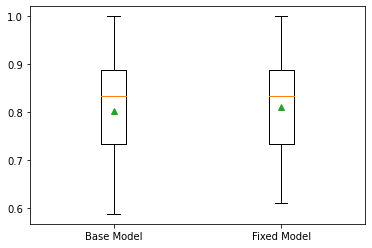

Base Accuracy: 0.803 (0.103)
Tuned Accuracy: 0.811 (0.100)


In [16]:
# define the model
baseModel = RandomForestClassifier()
tunedModel = RandomForestClassifier(max_samples=0.4, max_features=3, n_estimators=750)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
b_scores = cross_val_score(baseModel, X_test, Y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
t_scores = cross_val_score(tunedModel, X_test, Y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
scores = [b_scores, t_scores]
# report performance
plt.boxplot(scores,labels=['Base Model','Fixed Model'],showmeans=True)
plt.show()
print('Base Accuracy: %.3f (%.3f)' % (mean(b_scores), std(b_scores)))
print('Tuned Accuracy: %.3f (%.3f)' % (mean(t_scores), std(t_scores)))

* Se obtuvo una mejora de accuracy de: 0.8.3 en modelo sin ajustar a: 0.811 en el modelo ajustado, con un cambio en la desviación estandar de: 0.103  a: 0.100

Ahora se procederá a calcular la importancia de cada atributo para la toma de decisiones del modelo:

Feature: 0, Score: 0.07502
Feature: 1, Score: 0.34771
Feature: 2, Score: 0.15412
Feature: 3, Score: 0.04930
Feature: 4, Score: 0.03490
Feature: 5, Score: 0.24228
Feature: 6, Score: 0.05211
Feature: 7, Score: 0.04456


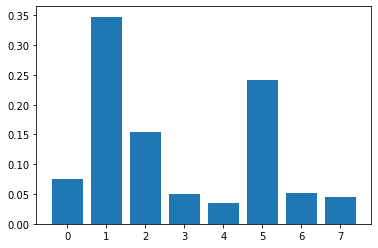

In [21]:
tunedModel = RandomForestClassifier(max_samples=0.4, max_features=3, n_estimators=750)
tunedModel.fit(X_test,Y_test)
# get importance
importance = tunedModel.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

* Se puede ver que en el caso del modelo generado con el algoritmo de Random Forest los atributos más relevantes son: Sex, Age y Fare. Sorprendentemente la clase del tiquete no es usada como uno de los predictores más fuertes.

# Extra Trees

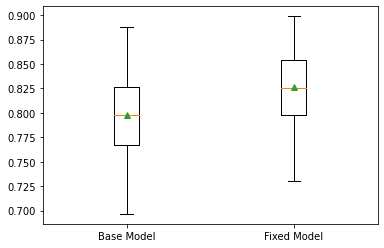

Base Accuracy: 0.798 (0.044)
Tuned Accuracy: 0.826 (0.042)


In [22]:
# define the model
baseModel = ExtraTreesClassifier()
tunedModel = ExtraTreesClassifier(n_estimators=500, max_features=8, min_samples_split=8)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
b_scores = cross_val_score(baseModel, inputColumns, outputColumn, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
t_scores = cross_val_score(tunedModel, inputColumns, outputColumn, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
scores = [b_scores, t_scores]
# report performance
plt.boxplot(scores,labels=['Base Model','Fixed Model'],showmeans=True)
plt.show()
print('Base Accuracy: %.3f (%.3f)' % (mean(b_scores), std(b_scores)))
print('Tuned Accuracy: %.3f (%.3f)' % (mean(t_scores), std(t_scores)))

* Se obtuvo una mejora de accuracy de: 0.798 en modelo sin ajustar a: 0.826 en el modelo ajustado, con un cambio en la desviación estandar de: 0.044  a: 0.042

Ahora se procederá a calcular la importancia de cada atributo para la toma de decisiones del modelo:

Feature: 0, Score: 0.06824
Feature: 1, Score: 0.56424
Feature: 2, Score: 0.10989
Feature: 3, Score: 0.04356
Feature: 4, Score: 0.02231
Feature: 5, Score: 0.11310
Feature: 6, Score: 0.06352
Feature: 7, Score: 0.01515


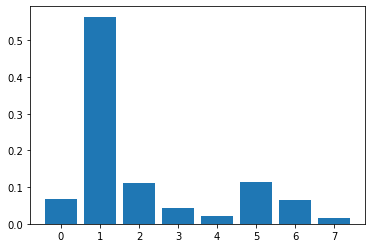

In [26]:
tunedModel = ExtraTreesClassifier(n_estimators=500, max_features=8, min_samples_split=8)
tunedModel.fit(X_test,Y_test)
# get importance
importance = tunedModel.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Se puede ver que en el caso del modelo generado con el algoritmo de Extra Trees los atributos más relevantes son tambíen: Sex, Age y Fare. Sorprendentemente la clase del tiquete tampoco es usada como uno de los predictores más fuertes en este caso.